# Ground truth

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import importlib.util
import sys

def load_module_from_path(module_name, module_path):
    spec = importlib.util.spec_from_file_location(module_name, module_path)
    module = importlib.util.module_from_spec(spec)
    sys.modules[module_name] = module
    spec.loader.exec_module(module)
    return module

# ====== rutas a tus archivos ======
base_path = "/content/drive/MyDrive/Balloon"

noise_path   = f"{base_path}/noise.py"
balloon_path = f"{base_path}/BalloonModelNet.py"

# ====== carga de módulos ======
noise   = load_module_from_path("noise", noise_path)
balloon = load_module_from_path("BalloonModelNet", balloon_path)

In [3]:
import numpy as np, random
np.random.seed(42)
random.seed(42)

def create_asym_matrix(D: int, scale: float = 0.5, sparsity: float = 0.3, seed: int = None):
    """
    Genera una matriz de conectividad asimétrica y esparsa.

    Parámetros
    ----------
    D : int
        Número de nodos/ROIs.
    scale : float
        Escala máxima de los pesos (valores en [-scale, scale]).
    sparsity : float
        Proporción de ceros (0 = densa, 1 = toda cero).
    seed : int
        Semilla para reproducibilidad.

    Retorna
    -------
    C : np.ndarray
        Matriz (D x D) asimétrica con cierta sparsity.
    """
    rng = np.random.default_rng(seed)

    # Matriz inicial con valores aleatorios
    C = rng.uniform(-scale, scale, size=(D, D))

    # Impone sparsity
    mask = rng.random(size=(D, D)) < sparsity
    C[mask] = 0.0

    # Asegura asimetría: fuerza C ≠ C^T
    for i in range(D):
        for j in range(i):
            if C[i, j] != 0 and C[j, i] != 0:
                C[j, i] = 0.0  # elimina espejo

    np.fill_diagonal(C, 1)

    return C

In [4]:
from BalloonModelNet import gen_network_stimulus, BalloonNetwork_roiwise
from noise import GN_AR1_recurrent_Laplace
import numpy as np
import random as rn
from sklearn.preprocessing import StandardScaler

np.random.seed(42)
rn.seed(42)

# === Parámetros mínimos ===
TR, T, num_rois = 1.0, 3000, 10                               #####################################################
timeline = TR * np.arange(T)
conn_prop, SNR, rho = 0.6, 30.0, 0.3

A = create_asym_matrix(D=num_rois, scale=1.0, sparsity=conn_prop, seed=42)

# === 2) Estímulos por ROI ===
U = gen_network_stimulus(timeline, num_rois, nblocks=5, duration_range=(1, 3))
U = np.clip(U, -1.0, 1.0)

# === 3) Balloon ===
BN = BalloonNetwork_roiwise(timeline, U, A)
bold = np.asarray(BN["bold"])

scaler = StandardScaler()
bold = scaler.fit_transform(bold)

# === 4) Ruido AR(1) ===
sigma = (1.0 / float(SNR))**0.5
bold_noisy = bold + np.column_stack([
    GN_AR1_recurrent_Laplace(rho=float(rho), sigma1=sigma, size=bold.shape[0])
    for _ in range(num_rois)
])

print("bold_noisy shape:", bold_noisy.shape)  # (T, num_rois)

node 1
node 2
node 3
node 4
node 5
node 6
node 7
node 8
node 9
node 10
bold_noisy shape: (1499, 10)


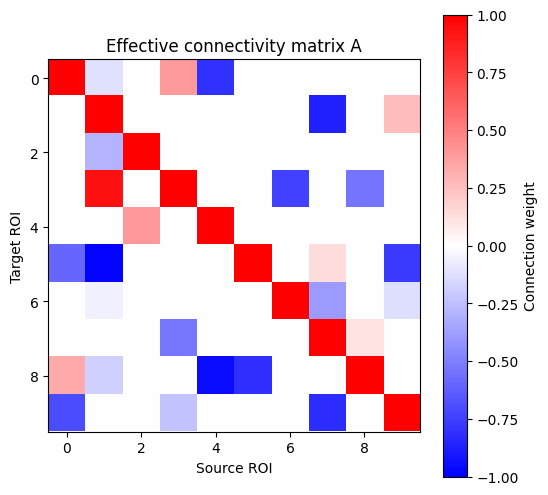

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.imshow(A, cmap="bwr", vmin=-1, vmax=1)
plt.colorbar(label="Connection weight")
plt.title("Effective connectivity matrix A")
plt.xlabel("Source ROI")
plt.ylabel("Target ROI")
plt.show()

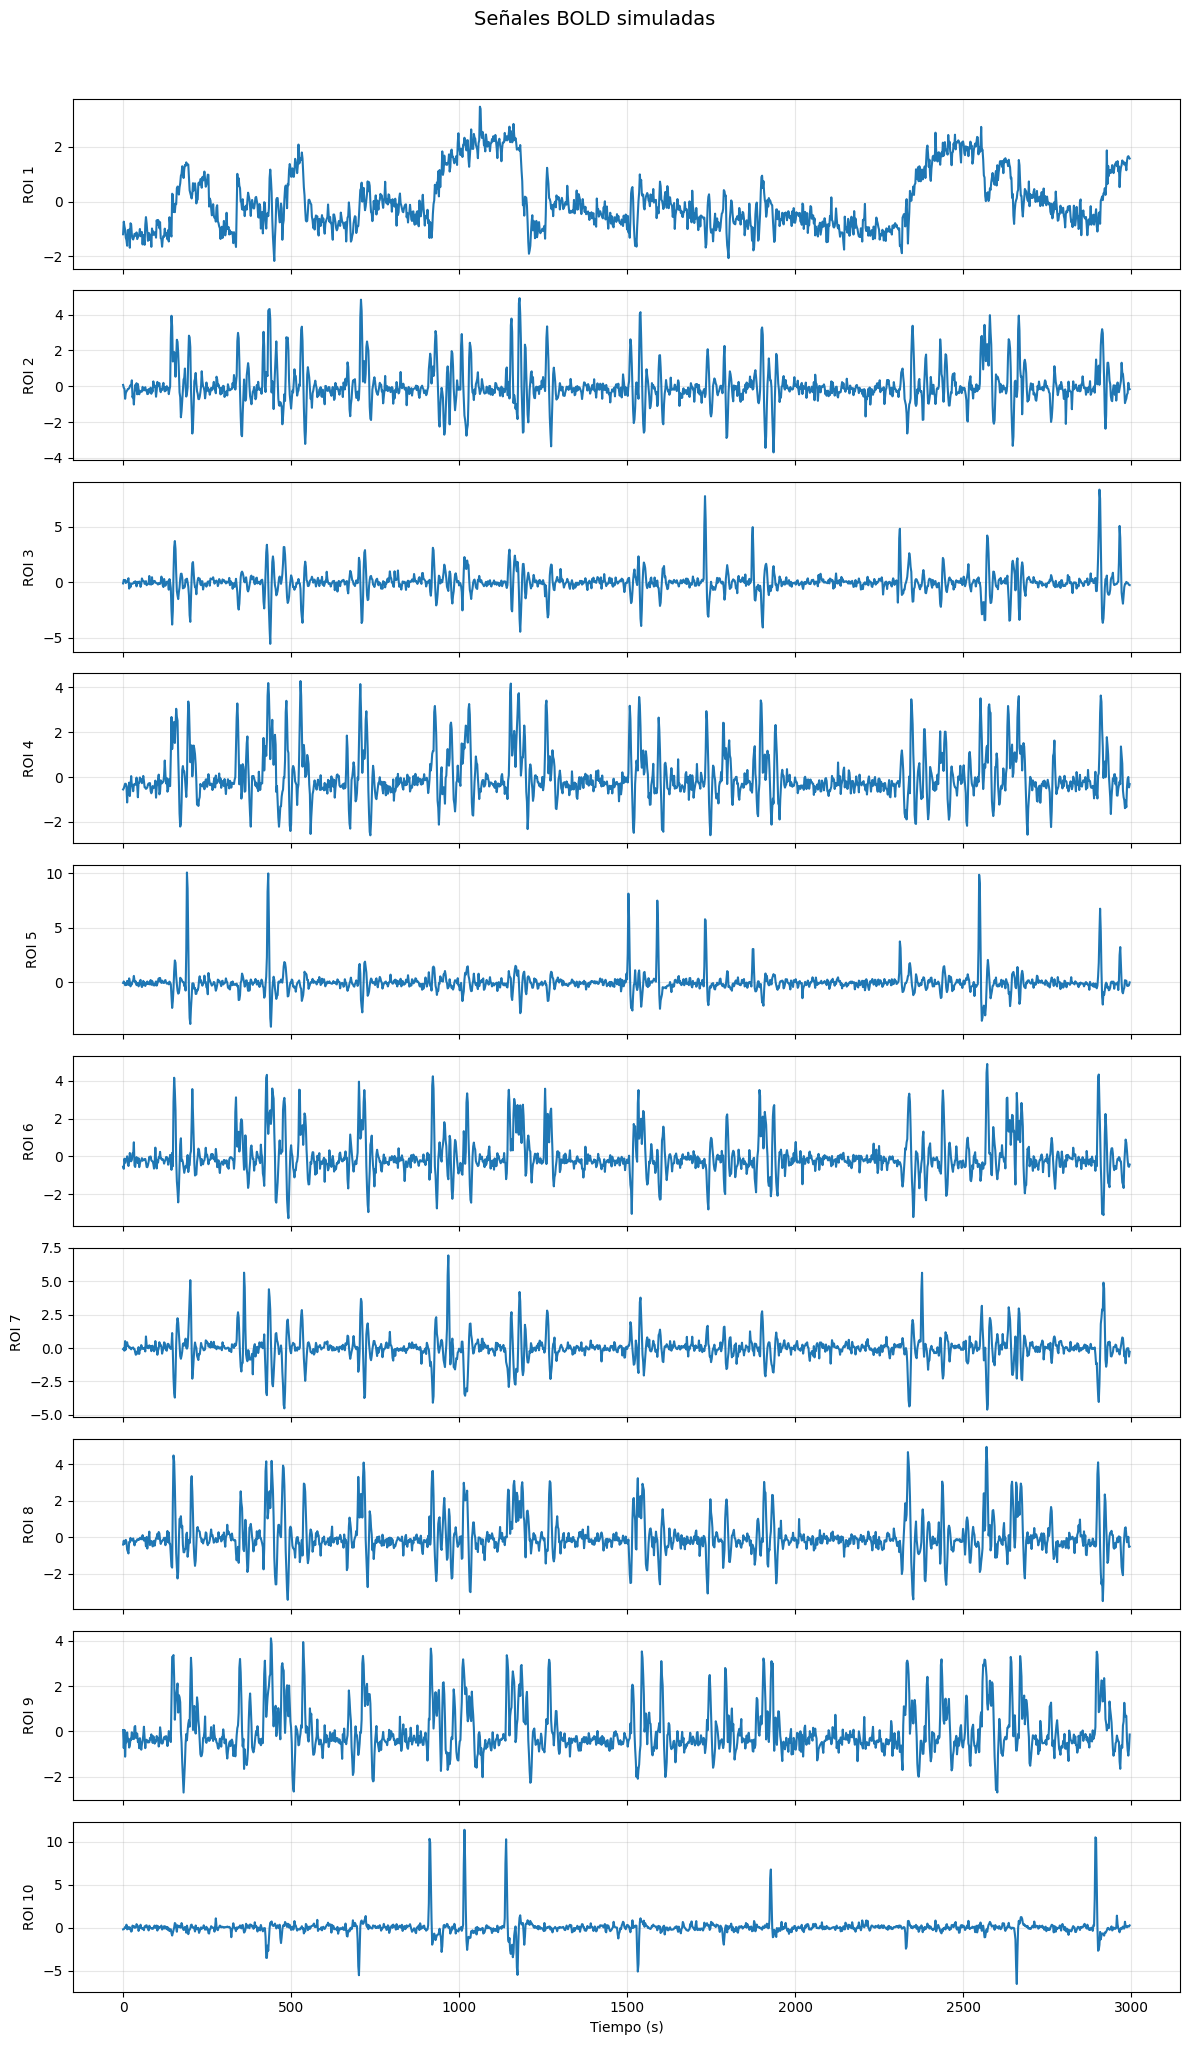

In [6]:
import matplotlib.pyplot as plt
import numpy as np

t = BN['tbold'][:, 0]  # eje de tiempo
n_rois = bold_noisy.shape[1]

fig, axes = plt.subplots(n_rois, 1, figsize=(12, 2*n_rois), sharex=True)

for i in range(n_rois):
    axes[i].plot(t, bold_noisy[:, i], color='tab:blue')
    axes[i].set_ylabel(f'ROI {i+1}')
    axes[i].grid(alpha=0.3)

axes[-1].set_xlabel("Tiempo (s)")
fig.suptitle("Señales BOLD simuladas", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

In [7]:
import numpy as np
import os

# Define la ruta donde quieres guardar el archivo en Google Drive
save_path = f"{base_path}/bold_noisy.npy"

# Asegúrate de que el directorio exista
os.makedirs(os.path.dirname(save_path), exist_ok=True)

# === Guardar señales simuladas ===
import numpy as np

base_path = "/content/drive/MyDrive/Balloon"

np.save(f"{base_path}/bold_clean.npy", bold)        # señal sin ruido
np.save(f"{base_path}/bold_noisy.npy", bold_noisy)  # señal con ruido

print("Archivos guardados en:", base_path)

Archivos guardados en: /content/drive/MyDrive/Balloon


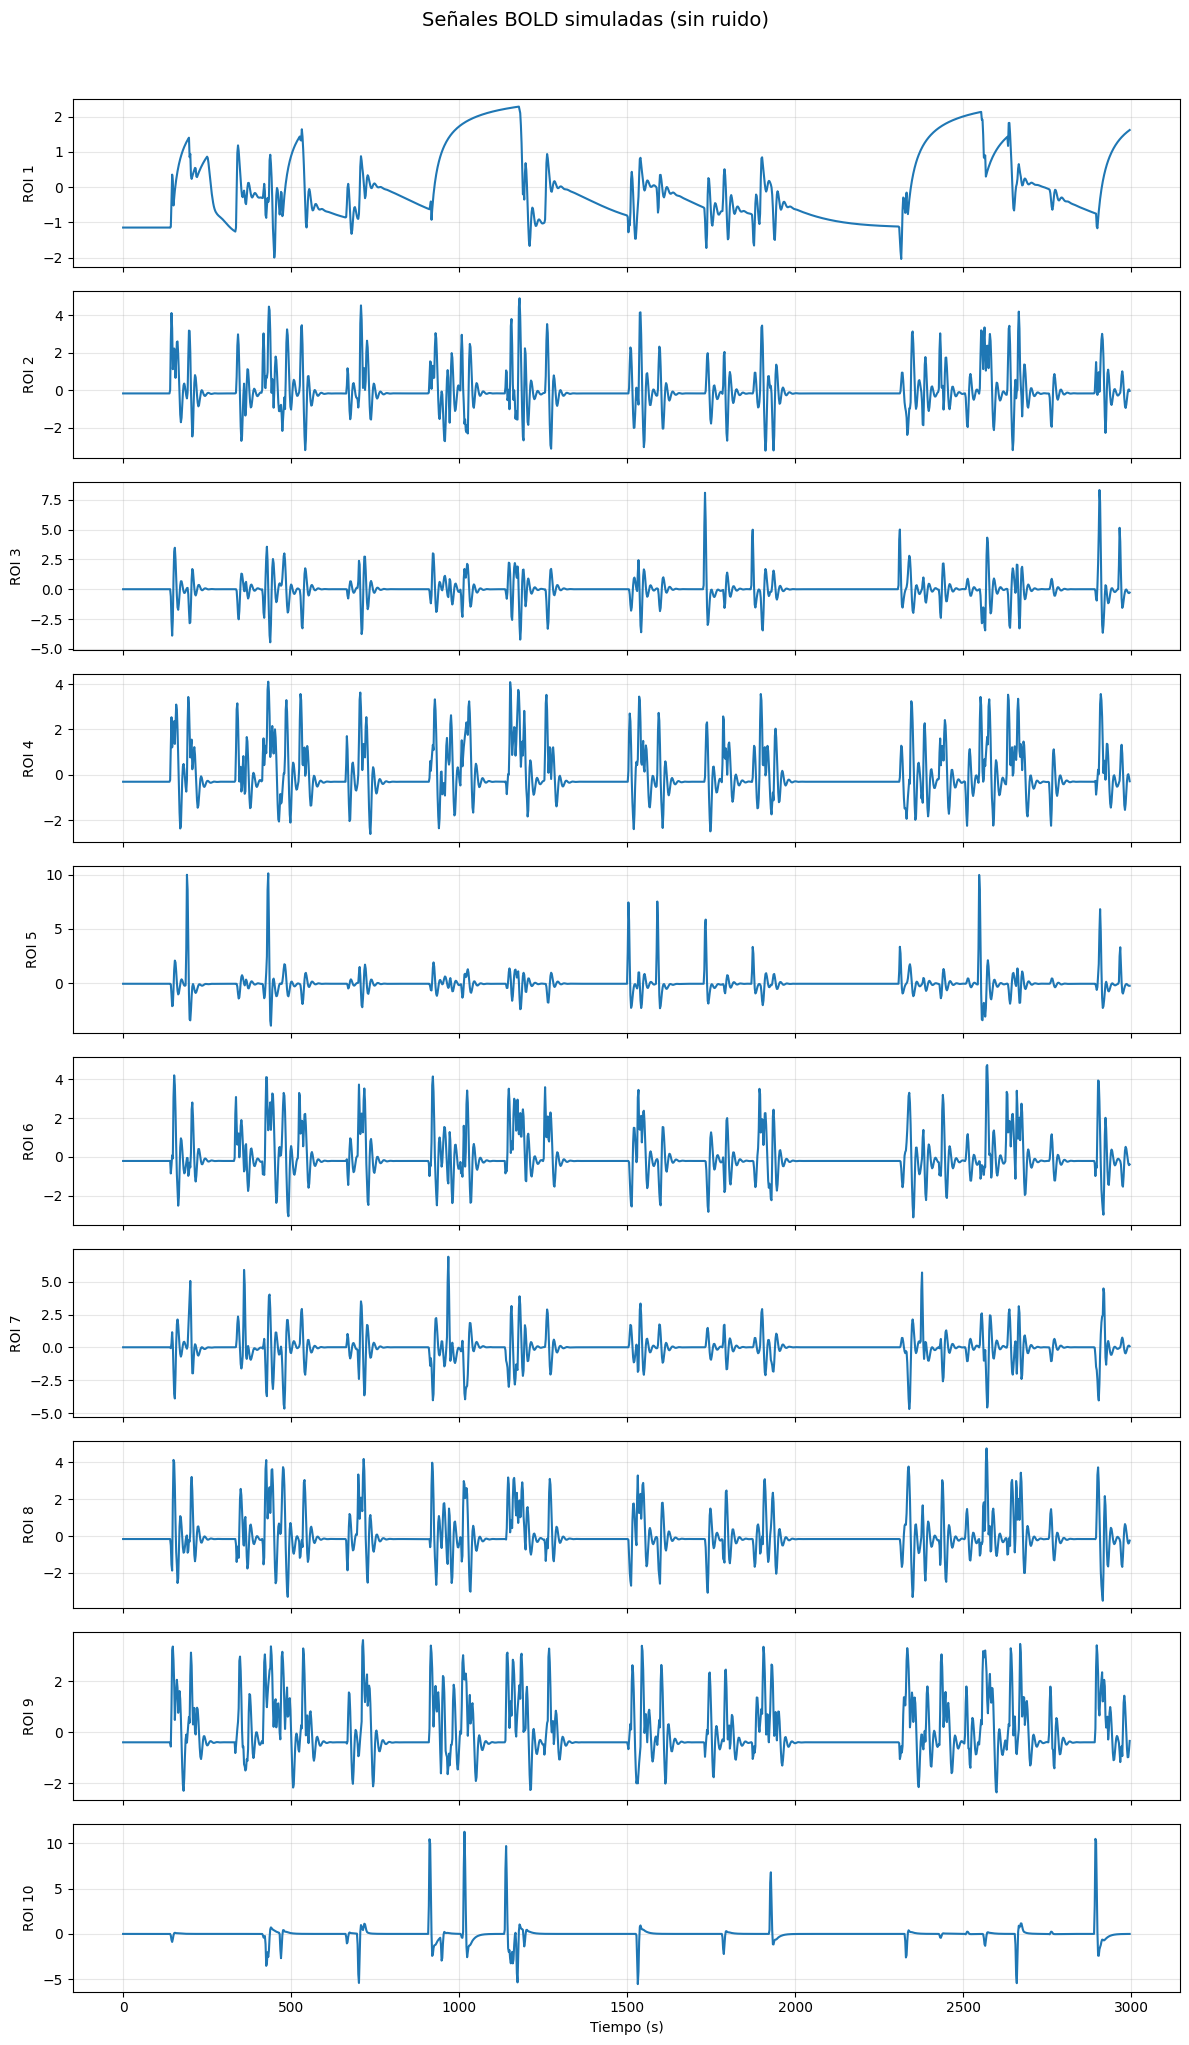

In [8]:
import matplotlib.pyplot as plt
import numpy as np

t = BN['tbold'][:, 0]  # eje de tiempo
n_rois = bold.shape[1]

fig, axes = plt.subplots(n_rois, 1, figsize=(12, 2*n_rois), sharex=True)

for i in range(n_rois):
    axes[i].plot(t, bold[:, i], color='tab:blue')
    axes[i].set_ylabel(f'ROI {i+1}')
    axes[i].grid(alpha=0.3)

axes[-1].set_xlabel("Tiempo (s)")
fig.suptitle("Señales BOLD simuladas (sin ruido)", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

In [9]:
# === Guardar ground truth y señales ===
import os, numpy as np

os.makedirs(base_path, exist_ok=True)

# matriz de conectividad neuronal (verdad-terreno)
np.save(f"{base_path}/A_true.npy", A)

# señales BOLD (ya las tienes)
np.save(f"{base_path}/bold_clean.npy", bold)
np.save(f"{base_path}/bold_noisy.npy", bold_noisy)

print("Guardados: A_true.npy, bold_clean.npy, bold_noisy.npy")

Guardados: A_true.npy, bold_clean.npy, bold_noisy.npy
